In [1]:
from torchvision import datasets
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [3]:
# 将数据reshape成对应格式
# 给数据添加噪声，并且控制像素值还是在0到255之间
# 对数据进行归一化
# 分训练和测试数据，这里选前50000数据训练，剩下的10000拿来测试

dataset = datasets.MNIST('data/',download=True)
data = dataset.data.reshape(-1, 1, 28, 28).float().to(device)

data_x = (data + 80 * torch.rand(60000, 1, 28, 28).to(device)).clamp(0, 255)/ 255.
# 添加噪声并归一化，数据x是添加噪声后的图
data_y = data / 255.
# 归一化，数据y是原图
plt.imshow(data_y[0].cpu().squeeze())
plt.show()
plt.imshow(data_x[0].cpu().squeeze())
plt.show()

# 分割训练和测试集
train_x, train_y = data_x[:50000], data_y[:50000]
test_x, test_y = data_x[50000:], data_y[50000:]

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.layer1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # (-1, 1, 28, 28) -> (-1, 32, 28, 28)
        self.layer2 = nn.MaxPool2d(2, stride=2)
        # (-1, 32, 28, 28) -> (-1, 32, 14, 14)
        self.layer3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.layer4 = nn.MaxPool2d(2, stride=2)
        # (-1, 32, 14, 14) -> (-1, 32, 7, 7)
        self.layer5 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.layer6 = nn.UpsamplingNearest2d(scale_factor=2)
        # (-1, 32, 7, 7) -> (-1, 32, 14, 14)
        self.layer7 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.layer8 = nn.UpsamplingNearest2d(scale_factor=2)
        # (-1, 32, 14, 14) -> (-1, 32, 28, 28)
        self.layer9 = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)
        # (-1, 32, 28, 28) -> (-1, 1, 28, 28)
    def forward(self,x):
        x = self.sigmoid(self.layer1(x))
        x = self.layer2(x)
        x = self.sigmoid(self.layer3(x))
        x = self.layer4(x)
        x = self.sigmoid(self.layer5(x))
        x = self.layer6(x)
        x = self.sigmoid(self.layer7(x))
        x = self.layer8(x)
        x = self.sigmoid(self.layer9(x))
        return x

model = net().to(device)

In [ ]:
loss_fun = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
batch_size = 1000
# 开始训练
model.train()
for epoch in range(50):
    for batch in range(0, 50000 - batch_size, batch_size):
        output = model(train_x[batch: batch+batch_size])
        loss = loss_fun(train_y[batch: batch+batch_size], output)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    test_output = model(test_x)
    loss_test = loss_fun(test_y, test_output)
    print('Epoch: {}, Loss: {}, test_loss: {}'.format(epoch, loss.data, loss_test.data))
    torch.save(model.state_dict(), "autodecode.mdl")

Epoch: 0, Loss: 0.05128490552306175, test_loss: 0.05083414912223816
Epoch: 1, Loss: 0.042078666388988495, test_loss: 0.04241403192281723
Epoch: 2, Loss: 0.03597678244113922, test_loss: 0.03688144311308861
Epoch: 3, Loss: 0.032854191958904266, test_loss: 0.03400741145014763
Epoch: 4, Loss: 0.03056945838034153, test_loss: 0.03165651485323906
Epoch: 5, Loss: 0.028449809178709984, test_loss: 0.029380569234490395
Epoch: 6, Loss: 0.026423156261444092, test_loss: 0.027144404128193855
Epoch: 7, Loss: 0.024575624614953995, test_loss: 0.025202328339219093


KeyboardInterrupt: 

/opt/anaconda3/envs/lxj/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/envs/lxj/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to revie

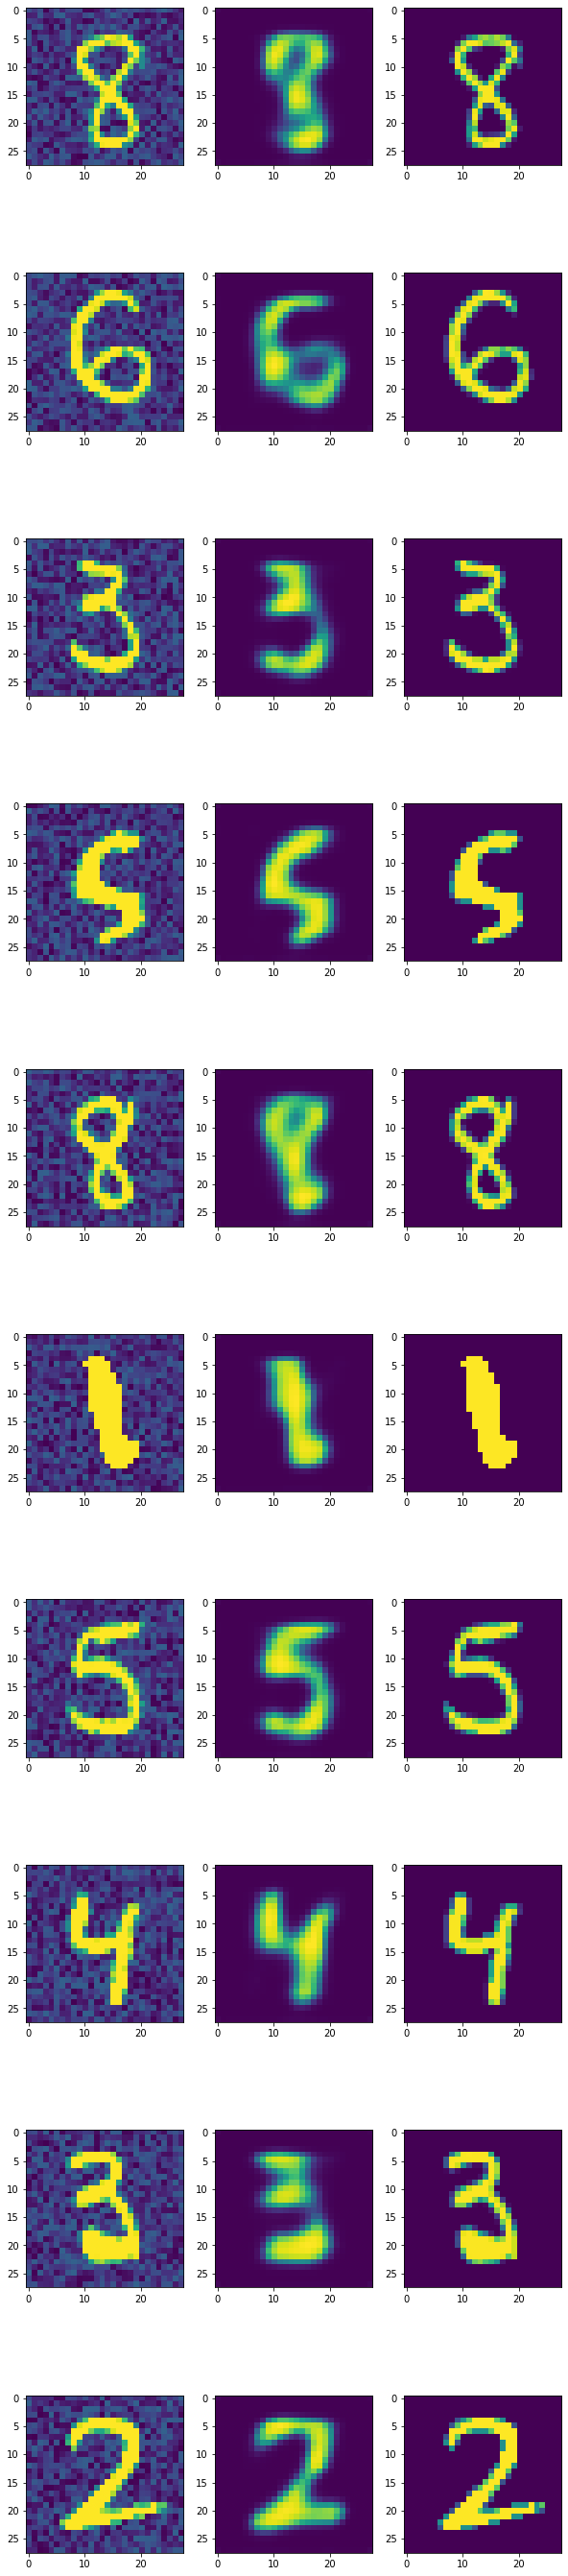

In [ ]:
model.eval()
test_output = model(test_x[:1000]).cpu()
train_output = model(train_x[:1000]).cpu()

# -----------------------------------
# 显示降噪后的效果对比
n = 10
plt.figure(figsize=(10, 50))
for i in range(n):
    ax = plt.subplot(n, 3, i*3 + 1)
    plt.imshow((test_x[i*3 + 1].cpu().squeeze().detach().numpy() * 255.).astype(np.int))
    ax = plt.subplot(n, 3, i*3 + 2)
    plt.imshow((test_output[i*3 + 1].cpu().squeeze().detach().numpy() * 255.).astype(np.int))
    ax = plt.subplot(n, 3, i*3 + 3)
    plt.imshow((test_y[i*3 + 1].cpu().squeeze().detach().numpy() * 255.).astype(np.int))
plt.show()